In [24]:
import cv2
import numpy as np
import os

def calculate_brightness(img):
    """Calculate the average brightness of the image."""
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def calculate_contrast(img):
    """Calculate the contrast of the image using standard deviation."""
    return np.std(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def calculate_sharpness(img):
    """Calculate the sharpness of the image using the variance of the Laplacian."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def calculate_histogram_stats(img):
    """Calculate the mean and standard deviation of the image histogram."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize histogram
    mean = np.sum(hist * np.arange(256))
    std = np.sqrt(np.sum(hist * (np.arange(256) - mean) ** 2))
    return mean, std

def extract_features(img):
    """Extract all features from the image."""
    brightness = calculate_brightness(img)
    contrast = calculate_contrast(img)
    sharpness = calculate_sharpness(img)
    hist_mean, hist_std = calculate_histogram_stats(img)
    return [brightness, contrast, sharpness, hist_mean, hist_std]

def prepare_dataset(low_light_dir, high_light_dir):
    """Prepare a dataset of features and delta values."""
    X = []  # Features from low-light images
    y = []  # Delta values (high-light features - low-light features)

    low_light_images = sorted(os.listdir(low_light_dir))
    high_light_images = sorted(os.listdir(high_light_dir))

    for low_img_path, high_img_path in zip(low_light_images, high_light_images):
        low_img = cv2.imread(os.path.join(low_light_dir, low_img_path))
        high_img = cv2.imread(os.path.join(high_light_dir, high_img_path))

        if low_img is None or high_img is None:
            continue

        # Extract features
        low_features = extract_features(low_img)
        high_features = extract_features(high_img)

        # Compute delta values
        delta = np.array(high_features) - np.array(low_features)
        X.append(low_features)
        y.append(delta)

    return np.array(X), np.array(y)

In [25]:
import cv2
import numpy as np
import os

def calculate_brightness(img):
    """Calculate the average brightness of the image."""
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def calculate_contrast(img):
    """Calculate the contrast of the image using standard deviation."""
    return np.std(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def calculate_sharpness(img):
    """Calculate the sharpness of the image using the variance of the Laplacian."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def calculate_histogram_stats(img):
    """Calculate the mean and standard deviation of the image histogram."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize histogram
    mean = np.sum(hist * np.arange(256))
    std = np.sqrt(np.sum(hist * (np.arange(256) - mean) ** 2))
    return mean, std

def extract_features(img):
    """Extract all features from the image."""
    brightness = calculate_brightness(img)
    contrast = calculate_contrast(img)
    sharpness = calculate_sharpness(img)
    hist_mean, hist_std = calculate_histogram_stats(img)
    return [brightness, contrast, sharpness, hist_mean, hist_std]

def prepare_dataset(low_light_dir, high_light_dir):
    """Prepare a dataset of features and delta values."""
    X = []  # Features from low-light images
    y = []  # Delta values (high-light features - low-light features)

    low_light_images = sorted(os.listdir(low_light_dir))
    high_light_images = sorted(os.listdir(high_light_dir))

    for low_img_path, high_img_path in zip(low_light_images, high_light_images):
        low_img = cv2.imread(os.path.join(low_light_dir, low_img_path))
        high_img = cv2.imread(os.path.join(high_light_dir, high_img_path))

        if low_img is None or high_img is None:
            continue

        # Extract features
        low_features = extract_features(low_img)
        high_features = extract_features(high_img)

        # Compute delta values
        delta = np.array(high_features) - np.array(low_features)
        X.append(low_features)
        y.append(delta)

    return np.array(X), np.array(y)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare dataset
low_light_dir = "./lol_dataset/our485/low"
high_light_dir = "./lol_dataset/our485/high"
X, y = prepare_dataset(low_light_dir, high_light_dir)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expand features into polynomial terms (e.g., quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a Linear Regression model on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Evaluate the model
y_pred = model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 174138.57473954622


In [26]:
def predict_deltas(img, model, poly):
    """Predict the delta values for a new low-light image."""
    # Extract features from the low-light image
    low_features = extract_features(img)
    low_features = np.array(low_features).reshape(1, -1)

    # Transform features into polynomial terms
    low_features_poly = poly.transform(low_features)

    # Predict delta values
    delta = model.predict(low_features_poly)[0]
    return delta

In [27]:
def apply_deltas(img, deltas):
    """
    Apply the predicted delta values to a low-light image.

    Args:
        img (numpy.ndarray): The low-light image (BGR format).
        deltas (list or numpy.ndarray): Predicted delta values for brightness, contrast, sharpness, etc.

    Returns:
        numpy.ndarray: The enhanced image.
    """
    # Unpack the delta values
    delta_brightness, delta_contrast, delta_sharpness, delta_hist_mean, delta_hist_std = deltas

    # Adjust brightness and contrast
    alpha = 1 + delta_contrast / 100  # Contrast adjustment factor
    beta = delta_brightness  # Brightness adjustment factor
    enhanced_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Adjust sharpness (using a simple kernel-based approach)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    enhanced_img = cv2.filter2D(enhanced_img, -1, kernel * (1 + delta_sharpness / 100))

    return enhanced_img

Predicted Deltas: [ 5.54375000e+01  1.45625000e+01 -1.65000000e+02 -8.97645950e-05
 -2.02941895e-03]


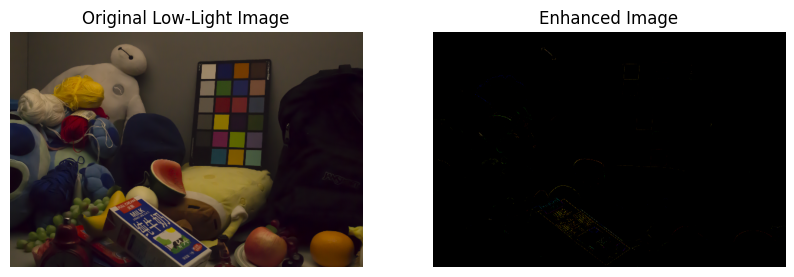

In [28]:
# Load a low-light image
test_image_path = "./lol_dataset/our485/low/464.png"
test_image = cv2.imread(test_image_path)

# Predict deltas (using the polynomial regression model)
deltas = predict_deltas(test_image, model, poly)
print("Predicted Deltas:", deltas)

# Apply the deltas to the image
enhanced_image = apply_deltas(test_image, deltas)

# Display the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Original Low-Light Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
plt.title("Enhanced Image")
plt.axis("off")

plt.show()